In [1]:
import pandas as pd
import numpy as np
import ast
import skimage.io as io
from skimage import color, measure
from skimage.transform import resize
from skimage.measure import regionprops_table
from skimage.segmentation import felzenszwalb
from kneed import KneeLocator # 用于拐点分析
import matplotlib.pyplot as plt 

In [2]:
# 函数6：将给定的颜色图添加至灰度图
def gray2color(gray_array, color_map):  
    '''Apply color map to the gray image.'''
    maxi = gray_array.max()
    mini = gray_array.min()
    gray_rescale = np.int_(gray_image * 
                           np.ones(gray_image.shape) / maxi * 255)
    rows, cols = gray_array.shape
    color_array = np.zeros((rows, cols, 3), np.uint8) 

    for i in range(0, rows):
        for j in range(0, cols):
            color_array[i, j] = color_map[gray_rescale[i, j]]  
    return color_array

In [3]:
# 加载深度学习穗粒分类模型
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torchvision import models

import torchvision
import torchvision.models as models
import torch.nn as nn
from PIL import Image
model = torchvision.models.vgg16(pretrained=False)
model.classifier._modules['6'] = nn.Linear(4096, 3)
model.load_state_dict(torch.load(r'./Data/model_weights.pth'))
model.cuda()
model.eval()

tran = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [4]:
datacube_1 = pd.read_csv(r'./Data/datacubes/datacube_1.csv', index_col=0)

In [5]:
# 读取原始图像
img_path = r'./Data/images/室内采集图像.JPG'
# img_path = r'./Data/images/手机采集图像.JPG'
source_img = io.imread(img_path)
# 从多维数据集中读取图像
image_resized = np.array(ast.literal_eval(datacube_1.at[0, 'image_resized']))
matched = np.array(ast.literal_eval(datacube_1.at[0, 'matched']))
Final_Spike_ROI_1 = np.array(ast.literal_eval(datacube_1.at[0, 'spike_mask']))

In [6]:
# 提取jet颜色图数据
from matplotlib import cm 
colormap_int = np.zeros((256, 3), np.uint8)
colormap_float = np.zeros((256, 3), np.float) 

for i in range(0, 256, 1):
    colormap_float[i, 0] = cm.jet(i)[0]
    colormap_float[i, 1] = cm.jet(i)[1]
    colormap_float[i, 2] = cm.jet(i)[2] 
        
    colormap_int[i, 0] = np.int_(np.round(cm.jet(i)[0] * 255.0))
    colormap_int[i, 1] = np.int_(np.round(cm.jet(i)[1] * 255.0))
    colormap_int[i, 2] = np.int_(np.round(cm.jet(i)[2] * 255.0)) 

C:\Users\win\AppData\Local\Temp/ipykernel_8248/519596690.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  colormap_float = np.zeros((256, 3), np.float)


In [7]:
# 提取穗粒区域灰度图并添加伪色
gray_image = image_resized[:,:,0] * Final_Spike_ROI_1
color_image = gray2color(gray_image, colormap_int)

In [8]:
# 结合超像素分割和深度学习分类，分析分割比率
num_dt = pd.DataFrame(columns=['No', 'intact_num'])
ratio_list = range(200,1500,100)
for n, ratio in enumerate(ratio_list):
    segments_fz = felzenszwalb(color_image, scale=10, sigma=0.05, min_size=int(np.sum(Final_Spike_ROI_1 > 0)/ratio))
    grain_props = measure.regionprops_table(segments_fz, color.rgb2gray(image_resized), 
                                            properties=['label', 'bbox', 'major_axis_length', 'minor_axis_length', 'area',  
                                                       'extent', 'solidity', 'image', 'intensity_image'], cache=True)
    grain_data = pd.DataFrame(grain_props)
    for i in (grain_data.index):
        min_row = grain_data.loc[i,'bbox-0']
        min_col = grain_data.loc[i,'bbox-1']
        max_row = grain_data.loc[i,'bbox-2']
        max_col = grain_data.loc[i,'bbox-3']

        min_row_b = int(grain_data.loc[i,'bbox-0'] / image_resized.shape[0] * source_img.shape[0])
        min_col_b = int(grain_data.loc[i,'bbox-1'] / image_resized.shape[1] * source_img.shape[1])
        max_row_b = int(grain_data.loc[i,'bbox-2'] / image_resized.shape[0] * source_img.shape[0])
        max_col_b = int(grain_data.loc[i,'bbox-3'] / image_resized.shape[1] * source_img.shape[1])

        mask_b = resize(grain_data.loc[i,'image'], (max_row_b - min_row_b, max_col_b - min_col_b))
        big_grain = (color.gray2rgb(mask_b)*source_img[min_row_b:max_row_b, min_col_b: max_col_b]).astype('int') # 原始大图中穗粒
        big_grain = Image.fromarray(big_grain.astype('uint8'), mode='RGB')
        big_grain = tran(big_grain).cuda()
        big_grain.unsqueeze_(dim=0)

        out = model(big_grain)
        pred = torch.max(out, 1)[1][0].item()
        grain_data.at[i, 'pred'] = pred
    intact_grain = grain_data[grain_data['pred'] == 1]
    intact_grain.reset_index(drop=True, inplace=True)
    num_dt.at[n, 'No'] = n
    num_dt.at[n, 'intact_num'] = len(intact_grain) if len(intact_grain)!=0 else len(intact_grain)+1
    num_dt.at[n, 'ratio'] = ratio

for i in num_dt.index[1:]:
    num_dt.at[i, 'incre'] = (num_dt.at[i, 'intact_num'] -  num_dt.at[i-1, 'intact_num']) / num_dt.at[i-1, 'intact_num']

kneedle_cov_dec = KneeLocator(num_dt['No'].astype('int')[1:], 
                      num_dt['incre'][1:], 
                      curve='convex', 
                      direction='decreasing',
                      online=True)
kneedle_cov_inc = KneeLocator(num_dt['No'].astype('int')[1:], 
                      num_dt['incre'][1:], 
                      curve='convex', 
                      direction='increasing',
                      online=True)

if num_dt.at[kneedle_cov_dec.knee, 'ratio'] < num_dt.at[kneedle_cov_inc.knee, 'ratio']:
    best_ratio = num_dt.at[kneedle_cov_dec.knee, 'ratio']
else:
    best_ratio = num_dt.at[kneedle_cov_inc.knee, 'ratio']

Text(0, 0.5, '完整粒数量随min_size参数变化的相对增长率')

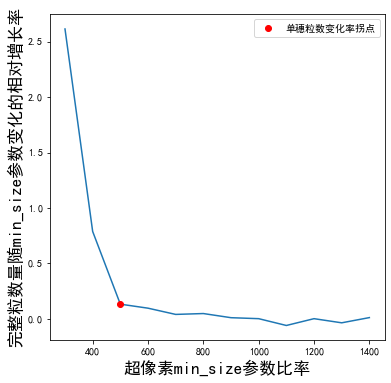

In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
plt.figure(figsize=(6,6))
plt.plot(num_dt['ratio'], num_dt['incre'])
plt.plot(num_dt.at[kneedle_cov_dec.knee, 'ratio'], kneedle_cov_dec.knee_y, 'ro', label = '单穗粒数变化率拐点')
plt.legend()
plt.xlabel('超像素min_size参数比率', fontsize=17)
plt.ylabel('完整粒数量随min_size参数变化的相对增长率', fontsize=17)

In [10]:
# 将最佳分割比率存放入多维数据集
datacube_1.loc[0, 'best_ratio'] = best_ratio
datacube_1.to_csv(r'./Data/datacubes/datacube_1.csv')